### This notebook plots the probability of beaching surface ocean circulation velocity overlay figure

In [9]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters')

In [10]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


from tqdm import tqdm
import netCDF4 as nc

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

from scipy.ndimage import gaussian_filter,  generic_filter

In [11]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [12]:
# load probability of beaching data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [13]:
# load circulation data
os.chdir('/home/openonic/global-drifter-program/')
circ = nc.Dataset('data/circulation.nc')

In [14]:
u = np.array(circ.variables['u'])[0]
v = np.array(circ.variables['v'])[0]
lats = np.array(circ.variables['latitude'])
lons = np.array(circ.variables['longitude'])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_la

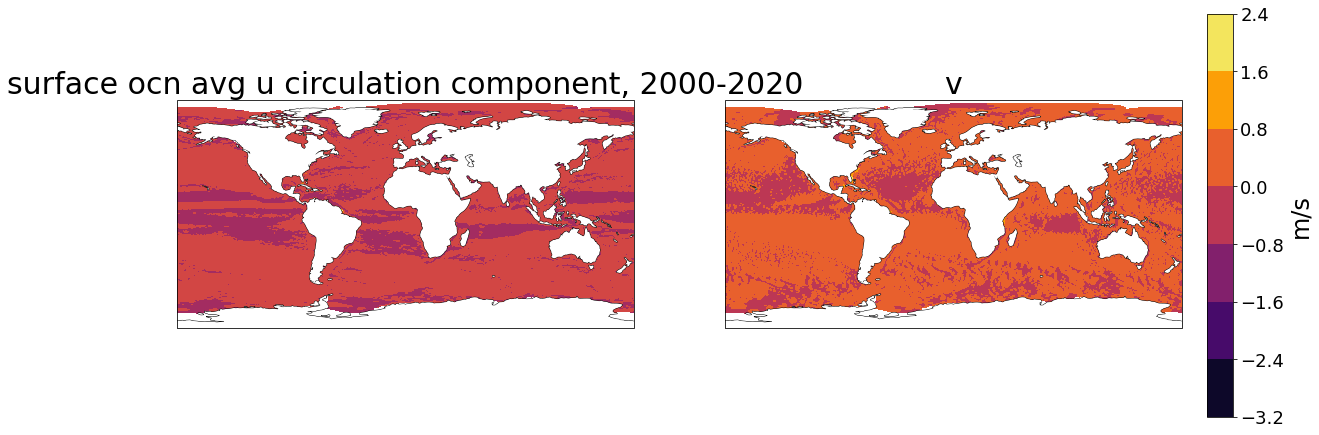

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, u, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('surface ocn avg u circulation component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, v, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('v')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

In [30]:
# we need to reduce the size of the data and average it some
def df_aggregation_by_factor_8(df):
    # keep original df unaffected
    working_df = df.copy()

    # initialize row mean:
    row_means = []
    
    # for each odd row    
    for i in tqdm(range(0, len(working_df), 2)):

        # initialize column mean:
        col_means = []
        
        # for each odd col
        for j in range(0, len(working_df.columns), 2):  

            # get 3x3 matrix around current grid cell
            matrix = working_df.iloc[i-1:i+2, j-1:j+2].values
            
            # get mean of matrix
            matrix_mean = matrix.mean()
            
            col_means.append(matrix_mean)
            
        row_means.append(col_means)
        
    result_df = pd.DataFrame(row_means)
    
    return result_df

In [37]:
# perform aggregation on wind dfs:
#u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:])))
#v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:])))
u_circ = df_aggregation_by_factor_8(df_aggregation_by_factor_8(pd.DataFrame(u).iloc[:-1,:]))
v_circ = df_aggregation_by_factor_8(df_aggregation_by_factor_8(pd.DataFrame(v).iloc[:-1,:]))

  0%|          | 0/720 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 360/360 [00:53<00:00,  6.70it/s]


In [101]:
# we have a problem: at 180 lon, there's a column of missing data
# this comes from the original data's projection. Let's fill in
# this missing data by interpolating between -179 and 179
smoothed_u = pd.DataFrame(u_circ)
smoothed_v = pd.DataFrame(v_circ)

smoothed_u[0] = smoothed_u[[1, 719]].mean(axis=1)
smoothed_v[0] = smoothed_v[[1, 719]].mean(axis=1)

In [85]:
# calculate probabilities of beaching

In [86]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

In [87]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [88]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [89]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [90]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [91]:
def nan_gaussian_filter(values, sigma):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# Apply the custom Gaussian filter
beach_prob_vals_filtered = nan_gaussian_filter(beach_prob_vals, sigma=1.4)

In [92]:
# define desired rows and desired cols
desired_rows = 720
desired_cols = 360
# define lat and lon
lats = np.linspace(-90,90,desired_cols)
lons = np.linspace(-180, 180, desired_rows)

In [ ]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals_filtered, cmap='inferno', transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, levels = 6)
#ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color='black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='whitesmoke')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # This sets the color limits for the ScalarMappable


# Plot wind vectors
linewidth = 1.5 + 10 * np.sqrt(smoothed_u.values**2 + smoothed_v.values**2) / np.sqrt(np.nanmax(smoothed_u.values)**2 + np.nanmax(smoothed_v.values)**2)
wind_q_global = ax1.streamplot(lons, lats, smoothed_u.values, smoothed_v.values, color='white', 
                               linewidth=linewidth, density = 2, arrowsize = 2, arrowstyle = '->')

#plt.savefig('prob_beach_winds.png', dpi=300)

# Show the plot
plt.show()